## Configs

In [54]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
from datetime import datetime

from utils.bs_funcs import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Options Data

In [55]:
## Dates
# start_dt = datetime(2024, 1, 1) 
# start = f'{start_dt.year}-{start_dt.month}-{start_dt.day}'
# end_dt = datetime.today()
# end = f'{end_dt.year}-{end_dt.month}-{end_dt.day}'

## download stock data
ticker = 'BOVA11'
yf_ticker = [f'{ticker}.SA']
stock_df =  get_stock_data(yf_ticker, period='1Y')
S = stock_df.iloc[-1]['Close']  # Preço Ação
print(f'Current Underlying Price: {S:.2f}')

[*********************100%%**********************]  1 of 1 completed

Current Underlying Price: 130.34


In [56]:
exp_date_front = '2024-09-20'
            
options_chain_front = get_options_chain(ticker, exp_date_front) 
options_chain_front.iloc[(options_chain_front['Strike'] - S).abs().argsort()][:2]

,Option,Type,E/A,Moneyness,Strike,Distance,Premium,volume,abs_Distance
29,BOVAI130,CALL,A,ATM,130.0,-0.38,3.07,18994835.23,0.38
112,BOVAU130,PUT,E,ATM,130.0,-0.38,1.50,5850310.11,0.38


In [57]:
## Collect back month data to get the strikes and premium of the operation
exp_date_back = '2024-10-18'
            
options_chain_back = get_options_chain(ticker, exp_date_back)
options_chain_back.iloc[(options_chain_back['Strike'] - S).abs().argsort()][:2]

,Option,Type,E/A,Moneyness,Strike,Distance,Premium,volume,abs_Distance
32,BOVAJ130,CALL,A,ATM,130.0,-0.38,4.42,2275300.77,0.38
109,BOVAV130,PUT,E,ATM,130.0,-0.38,2.00,636573.28,0.38


## Rets/Vol

In [58]:
r = 0.1025 # taxa livre de risco # automatiza depois

K = options_chain_back[(options_chain_back['Moneyness'] == 'ATM') & (options_chain_back['Type'] == 'CALL')].sort_values('abs_Distance')[:1]['Strike'].iloc[0] # Strike 
dte = (datetime.strptime(exp_date_back, '%Y-%m-%d') - datetime.today()).days # dia ate vencimento  
T = dte/252   # ano até vencmento
market_price = options_chain_back[(options_chain_back['Moneyness'] == 'ATM') & (options_chain_back['Type'] == 'CALL')].sort_values('abs_Distance')[:1]['Premium'].iloc[0]  # Market price of the option

In [59]:
rets = stock_df[['Close']].pct_change().dropna()
mu = annualized_returns(rets, dte)
ann_mu = annualized_returns(rets, 252)

sigma = yang_zhang_volatility(stock_df, dte, annualized=False) 
ann_sigma = yang_zhang_volatility(stock_df, dte, annualized=True)

print(f'MU: {mu:.2%}, SIGMA: {sigma.iloc[-1]:.2%}\nANN_MU: {ann_mu:.2%}, ann_sigma: {ann_sigma.iloc[-1]:.2%}')

MU: 5.37%, SIGMA: 6.86%
ANN_MU: 16.65%, ann_sigma: 13.84%


## Expected Move

In [84]:
front_atm_straddle = atm_straddle_short(options_chain_front, S)[0]
front_atm_straddle

ATM Straddle: 4.57
Range Expectation using ATM Straddle 125.77 e 134.91


4.57

In [88]:
def get_vol_from_straddle(straddle, S):
    return (straddle / S * 1.25)
    
vol_atm_straddle = get_vol_from_straddle(front_atm_straddle, S) 
print(f'{vol_atm_straddle:.2%}')

4.38%


In [60]:
## short options will be where straddle breaks-even


atm_straddle_approximation_short(S, ann_sigma.iloc[-1], dte)

mad_straddle_approximation_short(S, ann_sigma.iloc[-1], dte)

ATM Straddle: 6.42
Range Expectation using ATM Straddle 123.92 e 136.76
ATM Straddle: 8.94
Range Expectation using ATM Straddle Approximation 121.40 e 139.28
MAD Straddle: 7.16
Range Expectation using MAD Straddle 123.18 e 137.50


(7.155860649333228, 123.1841356885574, 137.49585698722385)

In [70]:
atm_straddle, lower, upper = mad_straddle_approximation_short(S, ann_sigma.iloc[-1], dte)

MAD Straddle: 7.16
Range Expectation using MAD Straddle 123.18 e 137.50


## Profit-to-Loss Ratio

In [62]:
wing_width = 3
long_put_strike, short_put_strike, short_call_strike, long_call_strike = select_iron_condor_strikes(lower, upper, options_chain_back, wing_width)

In [68]:
long_put_strike, short_put_strike, short_call_strike, long_call_strike 

(120.0, 123.0, 137.0, 140.0)

In [63]:
max_loss, gain_range, credit_received, profit, roc, leg_width = iron_condor(options_chain_back, long_put_strike, short_put_strike, short_call_strike, long_call_strike, qty=1)

Position Risk: 2.23
Gain Range: 14.00
Credit Received/Max Profit: $0.77
Managed Take Profit: $0.40
Managed ROIC (net): 17.96%


## Monte Carlo/Kelly Criterion

In [64]:
steps_per_year = 252
n_scenarios = 1000
n_years = dte/252  ## time to expiry in years

In [65]:
paths = gbm(n_years, n_scenarios, ann_mu, ann_sigma.iloc[-1], steps_per_year, S)

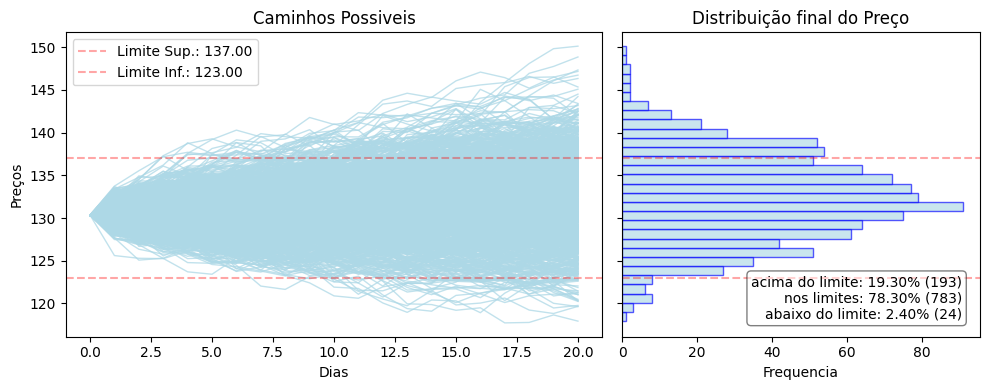

In [66]:
win_pct, loss_above, loss_bellow = plot_paths(paths[:21], ceiling=short_call_strike, floor=short_put_strike)

In [67]:
kelly_fraction, max_risk = kelly_criterion(win_pct, kelly=.5, bet_factor=roc, portfolio_size=10000)

print(f'Kelly Factor of total portfolio for this trade: {kelly_fraction:.2%} ')
print(f'Max Risk of this trade: R$ {max_risk:.2f}')

TypeError: kelly_criterion() got an unexpected keyword argument 'bet_factor'

In [ ]:
qty = math.floor(max_risk/max_loss)
print(f'Quantity of ICs to buy: {qty}')
iron_condor(options_chain_back, long_put_strike, short_put_strike, short_call_strike, long_call_strike, qty=qty)

Quantity of ICs to buy: 438
Position Risk: 950.46
Gain Range: 15.00
Credit Received/Max Profit: $363.54
Managed Take Profit: $189.04
Managed ROIC (net): 19.89%


(950.4600000000002,
 15.0,
 0.8299999999999998,
 0.43159999999999993,
 0.1988940092165898,
 3.0)

In [ ]:
## Black and Scholes Prices 
long_put_price = black_scholes(S, long_put_strike, T, r, ann_sigma.iloc[-1], 'p')
short_put_price = black_scholes(S, short_put_strike, T, r, ann_sigma.iloc[-1], 'p')
short_call_price = black_scholes(S, short_call_strike, T, r, ann_sigma.iloc[-1], 'c')
long_call_price = black_scholes(S, long_call_strike, T, r, ann_sigma.iloc[-1], 'c')
straddle_bs_price = long_put_price - short_put_price + short_call_price - long_call_price

print(f'Long Put Strike {long_put_strike}: price {long_put_price:.2f}')
print(f'Short Put Strike {short_put_strike}: price {short_put_price:.2f}')
print(f'Short Call Strike {short_call_strike}: price {short_call_price:.2f}')
print(f'Long Call Strike {long_call_strike}: price {long_call_price:.2f}')
print(f'ATM Straddle: price {straddle_bs_price:.2f}')

print(f'BS ROIC: {straddle_bs_price / (wing_width - straddle_bs_price):.2%}') 

Long Put Strike 120.0: price 0.20
Short Put Strike 123.0: price 0.46
Short Call Strike 138.0: price 1.98
Long Call Strike 141.0: price 1.21
ATM Straddle: price 0.52
BS ROIC: 21.11%


[Iron Condor](https://optionalpha.com/strategies/iron-condor)  
[Volatility Estimators - Portfolio Optimizer](https://portfoliooptimizer.io/blog/range-based-volatility-estimators-overview-and-examples-of-usage/)  
[Volatility Estimators - Hudson and Thames](https://www.mlfinlab.com/en/latest/feature_engineering/volatility_estimators.html)


